# Assignment 1

This assignment requires you to implement a K-Nearest Neighbors classifier and test it using the `column_2C_weka` data from the **Vertebral Column dataset**, which you can download from [this page on the UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/212/vertebral+column). It walks you through the steps of a typical machine learning workflow.

In [381]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

## Fetching and preparing the data

* **(5 points)** Read the `column_2C_weka` data of the above Vertebral Column dataset into a Pandas dataframe. The dataset contains six input features plus a binary target column(the output).

In [382]:
file_path = 'column_2C_weka.arff'

# Open the ARFF file and read its content
with open(file_path, 'r') as arff_file:
    # Skip lines until data starts
    while True:
        line = arff_file.readline()
        if line.lower().strip() == "@data":
            break

    # Read the data using pandas
    df = pd.read_csv(arff_file, header=None, delimiter=',')
    
    df.rename(columns={0 :'x1',1 :'x2',2 :'x3',3 :'x4',4 :'x5',5 :'x6',6 : 'y'}, inplace=True)
   
    ###The data is randomly shuffled###
    
    shuffled_df = df.sample(frac=1, random_state=17)

df = shuffled_df

df
    


,x1,x2,x3,x4,x5,x6,y
272,39.358705,7.011262,37.000000,32.347443,117.818760,1.904048,Normal
82,88.623908,29.089453,47.564262,59.534455,121.764780,51.805899,Abnormal
138,72.054034,24.700737,79.874016,47.353297,107.172358,56.426159,Abnormal
13,53.572170,20.460828,33.100000,33.111342,110.966698,7.044803,Abnormal
280,50.086153,13.430044,34.457541,36.656108,119.134622,3.089484,Normal
...,...,...,...,...,...,...,...
278,40.413366,-1.329412,30.982768,41.742778,119.335655,-6.173675,Normal
240,41.646916,8.835549,36.031975,32.811367,116.555168,-6.054538,Normal
143,60.626217,20.595958,64.535262,40.030259,117.225554,104.859247,Abnormal
241,51.529358,13.517847,35.000000,38.011510,126.718516,13.928331,Normal


* **(5 points)** Re-code the values of the output column to 0 for “Normal” and 1 for “Abnormal”.

In [383]:
df['y'] = df['y'].replace('Abnormal', 0)
df['y'] = df['y'].replace('Normal', 1)

df

,x1,x2,x3,x4,x5,x6,y
272,39.358705,7.011262,37.000000,32.347443,117.818760,1.904048,1
82,88.623908,29.089453,47.564262,59.534455,121.764780,51.805899,0
138,72.054034,24.700737,79.874016,47.353297,107.172358,56.426159,0
13,53.572170,20.460828,33.100000,33.111342,110.966698,7.044803,0
280,50.086153,13.430044,34.457541,36.656108,119.134622,3.089484,1
...,...,...,...,...,...,...,...
278,40.413366,-1.329412,30.982768,41.742778,119.335655,-6.173675,1
240,41.646916,8.835549,36.031975,32.811367,116.555168,-6.054538,1
143,60.626217,20.595958,64.535262,40.030259,117.225554,104.859247,0
241,51.529358,13.517847,35.000000,38.011510,126.718516,13.928331,1


* **(5 points)** Perform feature scaling by normalizing the values of each feature column. We use feature scaling to make sure that features with larger values do not render features with small values insignificant. Use the following formula for normalization: $$ x_{new}  = \frac{x - x_{min}}{x_{max} - x_{min}}$$

In [384]:
#Normalizing function for columns, using Xnew = (X - Xmin) / (Xmax - Xmin)
def Normalize_Col(df):
    df1 = df.copy()

    for n in df1.columns[:6]:
        col_min = df1[n].min()
        col_max = df1[n].max()
        
        #Normalize using Xnew = (X - Xmin) / (Xmax - Xmin)
        if (col_max - col_min) != 0:
            df1[n] = (df1[n] - col_min) / (col_max - col_min)

    return df1

normalized_df = Normalize_Col(df)

normalized_df.head()


,x1,x2,x3,x4,x5,x6,y
272,0.127411,0.242311,0.205831,0.175644,0.513356,0.030173,1
82,0.602549,0.636657,0.300372,0.427229,0.555792,0.146331,0
138,0.442741,0.558269,0.589517,0.314506,0.398864,0.157086,0
13,0.264493,0.482538,0.170929,0.182713,0.439669,0.042139,0
280,0.230872,0.356959,0.183078,0.215516,0.527507,0.032932,1


* **(5 points)** Split the dataset into two sets: 25% for testing and the rest for training.

In [385]:
#split the dataframe into two parts 75% for training and 25% for testing

test_split = int(0.75 * len(normalized_df))

training_df = normalized_df[0:test_split]
test_df = normalized_df[test_split:]

training_df.shape, test_df.shape

((232, 7), (78, 7))

## Implementing the classifier

* **(30 points)** Define a class named `KNearestNeighborClassifier` that generalizes the NearestNeighborClassifier of the `05.nearest_neighbors.ipynb` handout to `k` neighbors instead of just 1. The class must define a `fit()` and `predict()` methods just like `NearestNeighborClassifier` does.

In [386]:
class KNearestNeighborClassifier:
    def calc_distance(self, x, y):
        distance = 0.0
        for i in np.arange(len(x)):
            distance += (x[i] - y[i])**2
                
        return math.sqrt(distance)
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
        return self
        
    def predict(self, X_unseen, k):
    
        if X_unseen.ndim == 1:
         
            N = len(self.X)
            distances = np.full(N, 0.0)
            
            for i, ex in enumerate(self.X):
                distances[i] = self.calc_distance(X_unseen, ex)
            
            #K Nearest Neighbors
            KNN = np.argsort(distances)[:k]
            nearest_labels = self.y[KNN]

            unique_labels, counts = np.unique(nearest_labels, return_counts=True)
            predicted_label = unique_labels[np.argmax(counts)]
            
            return predicted_label
            
                    
        else:
                return np.array([self.predict(ex, k) for ex in X_unseen])

#X_train, y_train, x_test all come from the normalized and split DataFrame.
X_train = training_df[training_df.columns[:6]].copy().values
y_train = training_df['y'].copy().values
X_test = test_df[test_df.columns[:6]].copy().values
y_test = test_df['y'].copy().values
knn_classifier = KNearestNeighborClassifier()
knn_classifier.fit(X_train, y_train)
prediction = knn_classifier.predict(X_test, 2)

prediction


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0])

## Hyperparameter tuning using 10-fold cross-validation
* **(20 points)** Define a function that implements **10-fold cross-validation**. See the lecture notes for how such a function works. Use $1 - accuracy$ as an error measure. The learner in this case is your `KNearestNeighborClassifier` class and $k$ (the number of neighbors is the hyperparameter.

In [408]:
def Cross_validation(X_train, y_train, k, folds=10):
    fold_size = len(X_train) // folds
    errors = []

    for i in k:
        k_errors = []

        #idx keep track of where the fold is.
        for n in range(folds):
            start_idx = n * fold_size
            end_idx = (n + 1) * fold_size

            #X_cv_train keeps all data but the fold, X_cv_valid is just the fold.
            X_cv_train = pd.concat([X_train[:start_idx], X_train[end_idx:]])
            y_cv_train = pd.concat([y_train[:start_idx], y_train[end_idx:]])
            X_cv_valid = X_train[start_idx:end_idx]
            y_cv_valid = y_train[start_idx:end_idx]

            #run KNNC with new data
            classifier = KNearestNeighborClassifier()
            classifier.fit(X_cv_train.values, y_cv_train.values)
            fold_predict = classifier.predict(X_cv_valid.values, i)

            #accuracy is #correct / #allvalues, error is 1 - accuracy
            accuracy = np.mean(fold_predict == y_cv_valid.values)
            error = 1 - accuracy
            k_errors.append(error)

        #average error for K value
        mean_error = np.mean(k_errors)
        errors.append((i, mean_error))
        #errors.append((i, k_errors))
    return errors


X_train_df = training_df[training_df.columns[:6]].copy()    
y_train_df = training_df['y'].copy()

k_vals = np.arange(1,21)

cv_errors = Cross_validation(X_train_df, y_train_df, k_vals)

cv_errors

    
    

[(1, 0.2217391304347826),
 (2, 0.23913043478260873),
 (3, 0.2782608695652174),
 (4, 0.2652173913043478),
 (5, 0.2608695652173913),
 (6, 0.25217391304347825),
 (7, 0.23913043478260873),
 (8, 0.25217391304347825),
 (9, 0.2521739130434783),
 (10, 0.23478260869565223),
 (11, 0.20869565217391303),
 (12, 0.19565217391304346),
 (13, 0.2),
 (14, 0.2086956521739131),
 (15, 0.21304347826086953),
 (16, 0.21304347826086958),
 (17, 0.2217391304347826),
 (18, 0.21304347826086958),
 (19, 0.20869565217391303),
 (20, 0.20434782608695654)]

* **(10 points)** Use the above **10-fold cross-validation** function to plot the values of `k` (1 to 20) against their cross-validation errors. Using this plot, what is the best value for `k`?

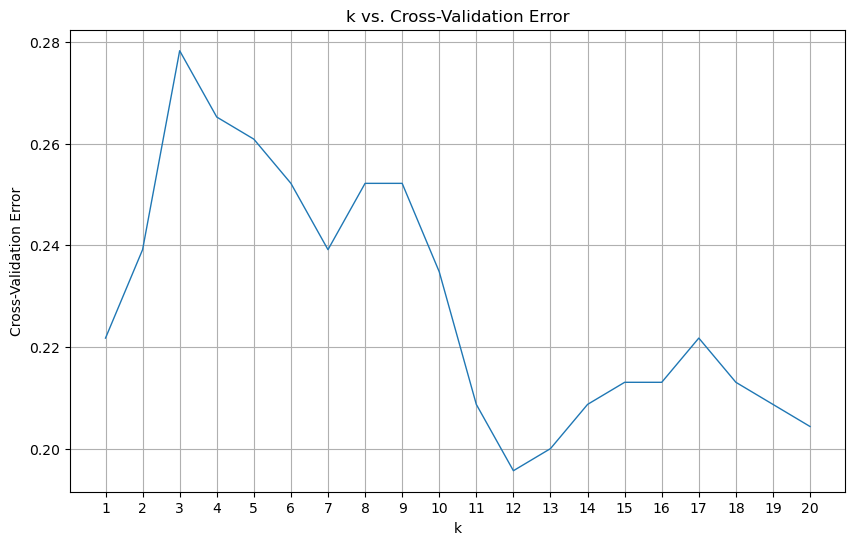

(12, 0.19565217391304346)

In [409]:
k_values, cross_val_errors = zip(*cv_errors)


#plot of all k vlaues and their errors
plt.figure(figsize=(10, 6))
plt.plot(k_values, cross_val_errors, linewidth = 1)
plt.title('k vs. Cross-Validation Error')
plt.xlabel('k')
plt.ylabel('Cross-Validation Error')
plt.xticks(k_values)
plt.grid(True)
plt.show()

#find best k and its error
best_k, best_error = cv_errors[1]
for k, e in cv_errors:
    if e < best_error:
        best_error = e
        best_k = k

#returns best K value and its error
best_k, best_error


## Testing the classifier
* **(10 points)** Train a model of the above `KNearestNeighborClassifier` with the “found-out” best `k` value. Test the trained model using the testing set. Show its confusion matrix and accuracy.

In [410]:
test_classifier = KNearestNeighborClassifier()
test_classifier.fit(X_train, y_train)
prediction_test = test_classifier.predict(X_test, best_k)

#confusion matrix generated from sklearn.metrics
confusion_matrix = metrics.confusion_matrix(y_test, prediction_test)

# Accuracy = TP + TN / ALL
cm_accuracy = (confusion_matrix[1][1:] + confusion_matrix[0][:1]) / np.sum(confusion_matrix) 

confusion_matrix, cm_accuracy

(array([[47, 10],
        [ 4, 17]]),
 array([0.82051282]))

* **(10 points)** Plot a point corresponding to the above confusion matrix on the ROC (Receiver Operating Characteristic) plot; no curve, just a point. Make sure to also plot the line from (0,0) to (1,1). 

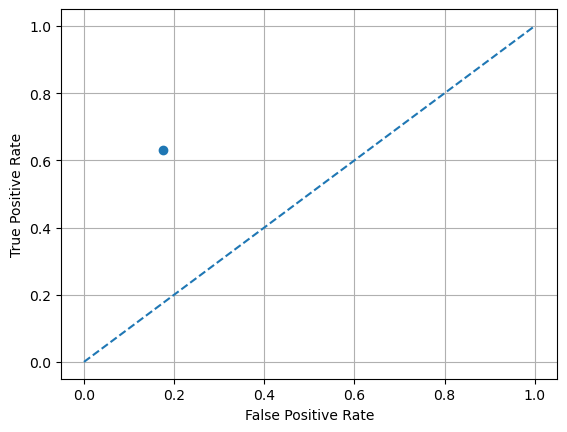

In [411]:
tp = confusion_matrix[1][1:]
fp = confusion_matrix[0][1:]
tn = confusion_matrix[0][:1]
fn = confusion_matrix[1][:1]

#ROC plot 
tpr = tp / (tp + fp)
fpr = fp / (fp + tn)

# graph
plt.scatter(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show the plot
plt.grid()
plt.show()
